In [98]:
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PATH_TO_OUTFILE = 'outfile.json'
TOTAL_SEATS = 660

In [74]:
def get_data() -> list[dict] | None:
    try:
        with open(PATH_TO_OUTFILE, 'r') as f:
            return json.load(f)
    except:
        return None

In [75]:
def convert_to_df(data:list[dict] ) -> pd.DataFrame:
    timestamps = [datetime.datetime.fromisoformat(data_item['timestamp']) for data_item in data if isinstance(data_item['data']['prices'], dict)]
    remaining_seats = [data_item['data']['prices']['5000'] for data_item in data if isinstance(data_item['data']['prices'], dict)]

    return pd.DataFrame({
        'timestamp': timestamps,
        'remaining_seat': remaining_seats,
    })

In [76]:
def get_daily_df(df: pd.DataFrame) -> pd.DataFrame:
    result = (df
              .resample('D', on='timestamp') 
              .last()
              .rename(columns={'remaining_seat': 'closing_seats'})
    )
    result['opening_seats'] = result['closing_seats'].shift(periods=1)
    result['sold'] = - (result['closing_seats'] - result['opening_seats'])
    result['weekly_sold'] = result['sold'].rolling(window=7).sum()
    return result

In [77]:
def get_hourly_df(df: pd.DataFrame) -> pd.DataFrame:
    result = df.resample('h', on='timestamp').last()
    return result

In [78]:
def plot_hourly_df(df: pd.DataFrame):    
    #x = pd.date_range(start='2024-09-03', end='2024-12-19', freq='h') # df.index
    x = df.index
    y = df['remaining_seat']

    fig, ax = plt.subplots()

    # set datetime axis
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    # add data
    ax.plot(x, y, color='#f8bbd0', zorder=3)
    plt.xticks(pd.date_range(start='2024-09-03', end='2024-12-19', freq='7D'))
    # add gridlines
    ax.yaxis.grid(which='major', color='lightgrey', zorder=0)
    # remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # remove y axis ticks
    ax.tick_params(axis=u'both', which=u'both',length=0)
    # format x axis
    plt.gcf().autofmt_xdate(rotation=90, ha='center')
    # add y axis limits
    ax.set_ylim([0, 660])
    # show last value as annotation
    value = df['remaining_seat'].iloc[-1]
    coord_x = df.index[-1] + datetime.timedelta(days=3)
    coord_y = value - 10
    ann = ax.annotate(value, [coord_x, coord_y])
    ann.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='grey'))

In [79]:
def plot_daily_df(df: pd.DataFrame):    
    fig, ax = plt.subplots()

    # set datetime axis
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))


    # add data
    bars = ax.bar(x=df.index, height=df['weekly_sold'], color='#f8bbd0', zorder=3)
    # add labels within box
    ax.bar_label(bars, label_type='center', rotation='vertical', fontsize=6)
    plt.xticks(pd.date_range(start='2024-09-03', end='2024-12-19', freq='7D'))
    # add gridlines
    ax.yaxis.grid(which='major', color='lightgrey', zorder=0)
    # remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # remove y axis ticks
    ax.tick_params(axis=u'both', which=u'both',length=0)
    # format x axis
    plt.gcf().autofmt_xdate(rotation=90, ha='center')

In [80]:
# def plot_daily_df(df: pd.DataFrame):    
#     fig, ax = plt.subplots()

#     # set datetime axis
#     fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))


#     # add data
#     bars = ax.bar(x=df.index, height=df['closing_seats'], color='#f8bbd0', zorder=3)
#     # add labels within box
#     ax.bar_label(bars, label_type='center', rotation='vertical', fontsize=6)
#     # add gridlines
#     ax.yaxis.grid(which='major', color='lightgrey', zorder=0)
#     # remove spines
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     # remove y axis ticks
#     ax.tick_params(axis=u'both', which=u'both',length=0)
#     # format x axis
#     plt.gcf().autofmt_xdate(rotation=90, ha='center')

In [81]:
# read file
data = get_data()
if data is None:
    raise SystemExit(0)

# convert to pandas df
raw_df = convert_to_df(data)

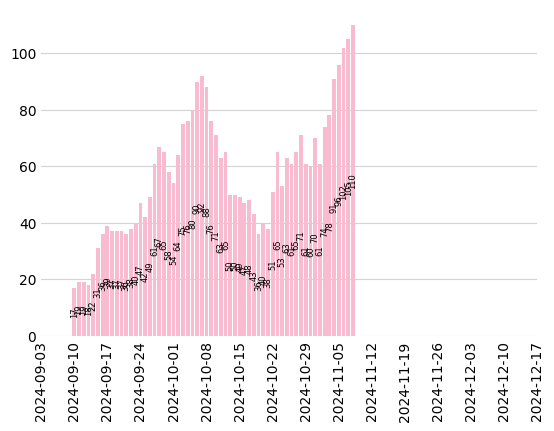

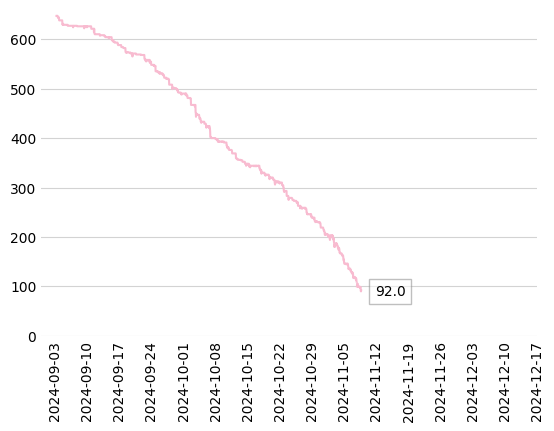

In [82]:
# napi-heti összegzések
df_daily = get_daily_df(raw_df)
df_hourly = get_hourly_df(raw_df)
plot_daily_df(df_daily)
plot_hourly_df(df_hourly)

In [105]:
def get_day_of_week_df(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy(deep=True)
    result ['week'] = result['timestamp'].dt.isocalendar().week
    result['DOW1'] = result['timestamp'].dt.dayofweek
    result['DOW2'] = result['timestamp'].dt.day_name(locale='HU')
    result = (result
              .resample('D', on='timestamp') 
              .last()
              .rename(columns={'remaining_seat': 'closing_seats'})
    )
    result['opening_seats'] = result['closing_seats'].shift(periods=1)
    result['sold'] = - (result['closing_seats'] - result['opening_seats'])
    result = result.drop(['opening_seats', 'closing_seats'], axis=1)
    result = result.iloc[1:, :]
    
    result = result.groupby(['week','DOW1', 'DOW2']).agg('mean').reset_index()
    result = result.round(1)
    
    result = pd.crosstab(
        index=result['week'],
        columns=result['DOW1'],
        values=result['sold'],
        aggfunc='sum'
    )
    return result

day_of_week_df = get_day_of_week_df(raw_df)
day_of_week_df

DOW1,0,1,2,3,4,5,6
week,,,,,,,
36,NaN,NaN,9.0,2.0,3.0,-2.0,0.0
37,2.0,3.0,11.0,2.0,2.0,2.0,9.0
38,7.0,6.0,9.0,2.0,2.0,1.0,11.0
39,9.0,13.0,4.0,9.0,14.0,7.0,9.0
40,2.0,9.0,14.0,20.0,15.0,11.0,19.0
41,4.0,5.0,2.0,15.0,7.0,13.0,4.0
42,4.0,4.0,0.0,16.0,2.0,6.0,8.0
43,2.0,17.0,14.0,4.0,12.0,4.0,12.0
44,8.0,7.0,13.0,14.0,3.0,17.0,16.0


In [140]:
def get_hour_of_day_df(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy(deep=True)
    result = (result
              .resample('h', on='timestamp') 
              .last()
              .rename(columns={'remaining_seat': 'closing_seats'})
              .reset_index()
    )
    result = result.ffill()
    result['HOD'] = result['timestamp'].dt.hour
    result['opening_seats'] = result['closing_seats'].shift(periods=1)
    result['sold'] = - (result['closing_seats'] - result['opening_seats'])
    result = result.drop(['timestamp', 'opening_seats', 'closing_seats'], axis=1)
    result = result.iloc[1:, :]
    
    result = result.groupby(['HOD']).agg('sum')

    result = result / result.sum()
    result['sold'] = result['sold'].map('{:.2%}'.format)

    return result

hour_of_day_df = get_hour_of_day_df(raw_df)
hour_of_day_df

,sold
HOD,
0,-0.72%
1,0.36%
2,0.00%
3,-0.18%
4,0.00%
5,0.18%
6,1.08%
7,0.18%
8,2.52%
